<a href="https://colab.research.google.com/github/Fuenfgeld/DMA2023TeamB/blob/main/Codes/DWH_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Zweck**: Exploratory Data Analysis (EDA) und Testen der Hypothesen im DWH



# 1) Einleitung

Mit diesem Skript werden die in das ANTICOVIS Data Warehouse ("DWH_covid19_ANTICOVIS_db.db") geladenen Daten im Hinblick auf die im Rahmen des ANTICOVIS Projekts formulierten Forschungsfragen analysiert:

1. Patient:innen mit Antikoagulation weisen im Vergleich zu nicht-antikoagulierten Patient:innen einen leichteren klinischen Covid 19-Erkrankungsverlauf auf.

2. Heparinderivate sind mit einem besseren klinischen Covid-19-Verlauf als andere Antikoagulantien assoziiert.

Das ANTICOVIS Data Warehouse liegt auf dem Google Drive von ANTICOVIS ab. Es ist nach einem Star-Schema konstruiert, welches aus Dimensions- und Faktentabellen besteht. Das Data Warehouse wurde mithilfe des auf GitHub abgelegten Files "ETL_and_Implementing_DWH.ipynb" erzeugt. 
 

# 2) Benötigte Libraries und Packages laden, Versionskontrolle und überprüfung der datensätze


In [26]:
import pandas as pd
import numpy as np
import sqlite3
from sqlalchemy.sql.expression import distinct 
!pip install pandasql
from pandasql import sqldf

import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("sqlite3 version:", sqlite3.version)
print("seaborn version:", sns.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26787 sha256=e8462c3d57614344f0617c470fbf0b64000ee3cc3754b71f7df7fedf22c6eea0
  Stored in directory: /root/.cache/pip/wheels/ed/8f/46/a383923333728744f01ba24adbd8e364f2cb9470a8b8e5b9ff
Successfully built pandasql
pandas version: 1.3.5
numpy version: 1.21.6
sqlite3 version: 2.6.0
seaborn version: 0.11.2


In [67]:
x= !ls "/content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldaten/covid19"
list_of_elements=''
for element in x:
  for x in range (len(element)):
    if element[x] == ' ' or element[x]=="\t":
      pass
    else:
      list_of_elements += element[x]

list_of_csvs = list_of_elements.split(".csv")
list_of_csv_files = list_of_csvs[0:-1]

df_of_csvs={}
for x in list_of_csv_files:
  path= f"/content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldaten/covid19/{x}.csv"
  df = pd.read_csv(path)
  df_of_csvs[x] = df

from pandas.util import hash_pandas_object
hashsum = 0
for key in df_of_csvs:
  if key == "pseudonym_tabelle":
    pass
  else:
    hashsum += hash_pandas_object(df_of_csvs[key]).sum()
print(hashsum)


<ipython-input-67-0b21270190e0>:25: RuntimeWarning: overflow encountered in long_scalars
  hashsum += hash_pandas_object(df_of_csvs[key]).sum()


-753198159639052557


hashsum = -753198159639052557

# 3) Mounten und Pfadangaben

In [1]:
from google.colab import drive
# Mounten des Drives für Data Warehouse Zugang
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Pfad des DWH
DB_DWH_PATH = "/content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/DWH/DWH_covid19_ANTICOVIS_db.db"

# Verbindung zum DWH
dwh_conn = sqlite3.connect(DB_DWH_PATH)

In [ ]:
# Liste der Tabellen im DWH
if dwh_conn is not None:
  dwh_cursor = dwh_conn.cursor()
  dwh_cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
  print("List of Tables", dwh_cursor.fetchall())


List of Tables [('d_conditions',), ('d_devices',), ('d_medications',), ('d_procedures',), ('F_ANTICOVIS',), ('d_patients',)]


# 4) Vorbereitende Schritte für die Datenanalyse

In [ ]:
# Einlesen der Query Resultate in ein Pandas Dataframe
df_faktentabelle = pd.read_sql_query("SELECT * FROM F_ANTICOVIS", dwh_conn)

In [ ]:
# .head() Prüfen der Resultate:
df_faktentabelle.head()

,patients_ID,conditions_code,procedures_code,devices_code,MED_CLASSIFICATION,COV_GRADING
0,kzjknynjzx,36955009.0,261352009.0,0.0,0,1
1,kzjknynjzx,386661006.0,261352009.0,0.0,0,1
2,kzjknynjzx,840539006.0,261352009.0,0.0,0,1
3,kzjknynjzx,840544004.0,261352009.0,0.0,0,1
4,upbzmcdmys,36955009.0,180325003.0,0.0,0,5


In [ ]:
# .shape returns the number of rows by the number of columns
#size of dataset
df_faktentabelle.shape

(608791, 6)

In [ ]:
# .columns zeigt die Namen aller Tabellen im DWH
df_faktentabelle.columns

Index(['patients_ID', 'conditions_code', 'procedures_code', 'devices_code',
       'MED_CLASSIFICATION', 'COV_GRADING'],
      dtype='object')

In [ ]:
# Anzeigen aller Attributinformationen
df_faktentabelle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608791 entries, 0 to 608790
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   patients_ID         608791 non-null  object 
 1   conditions_code     608791 non-null  float64
 2   procedures_code     608791 non-null  float64
 3   devices_code        608791 non-null  float64
 4   MED_CLASSIFICATION  608791 non-null  object 
 5   COV_GRADING         608791 non-null  int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 27.9+ MB


In [ ]:
#Beenden der DWH-Verbindung
#dwh_conn.close()

In [ ]:
# .nunique(axis=0) zeigt die Anzahl einzigartiger Variablen 
df_faktentabelle.nunique(axis=0)


patients_ID           1050
conditions_code         42
procedures_code         18
devices_code             7
MED_CLASSIFICATION       4
COV_GRADING              6
dtype: int64

# 5) Initiale Untersuchung der Covid Patient:innen und vorbereitende Schritte für die Datenanalyse



Covid Patient:innen:



In [ ]:

all_patients_that_had_covid = sqldf("""SELECT DISTINCT patients_id, conditions_code As Patients_With_Covid
                                                  FROM df_faktentabelle 
                                                  WHERE conditions_code = 840539006""")
all_patients_that_had_covid

,patients_ID,Patients_With_Covid
0,kzjknynjzx,840539006.0
1,upbzmcdmys,840539006.0
2,gkuamljbqc,840539006.0
3,cujrtqnldo,840539006.0
4,zrkdrzaziu,840539006.0
...,...,...
860,nnygehhqqh,840539006.0
861,tjjlajdifk,840539006.0
862,cilhvojejf,840539006.0
863,mqionduuuf,840539006.0


Covid Patient:innen ohne Antikoagulation: 


In [ ]:
all_COVID_19_Patients_That_did_not_Recieved_an_anticoagulation = sqldf("""SELECT DISTINCT patients_id As Patients_With_Covid 
                                                                  FROM df_faktentabelle 
                                                                  WHERE conditions_code = 840539006 AND MED_CLASSIFICATION = 0""")
all_COVID_19_Patients_That_did_not_Recieved_an_anticoagulation

,Patients_With_Covid
0,kzjknynjzx
1,upbzmcdmys
2,gkuamljbqc
3,cujrtqnldo
4,zrkdrzaziu
...,...
860,nnygehhqqh
861,tjjlajdifk
862,cilhvojejf
863,mqionduuuf


Covid Patient:innen mit Antikoagulation: 


In [ ]:
all_COVID_19_Patients_That_Recieved_an_anticoagulation = sqldf("""SELECT DISTINCT patients_id As Patients_With_Covid, MED_CLASSIFICATION
                                                                  FROM df_faktentabelle 
                                                                  WHERE conditions_code = 840539006 AND MED_CLASSIFICATION != 0""")

all_COVID_19_Patients_That_Recieved_an_anticoagulation

,Patients_With_Covid,MED_CLASSIFICATION
0,upbzmcdmys,3
1,cujrtqnldo,1
2,afolyayjzc,1
3,ggolrecrpi,1
4,aonaydsedd,1
...,...,...
197,ikgrkhklln,1
198,vpngrvnbtt,1
199,mqionduuuf,2
200,kyysqzamcz,2


Berechnung der Patient:innen der einzelnen Behandlungsgruppen (Behandlung mit Hepariderivaten, wo MED_CLASSIFICATION = 1, Behandlung mit Thrombozytenaggregationshemmern, wo MED_CLASSFICATION = 2, und Behandlung mit Vitamin K Antagonisten, wo MED_CLASSIFICATION = 3. 

In [ ]:
print(all_COVID_19_Patients_That_Recieved_an_anticoagulation.dtypes)

Patients_With_Covid    object
MED_CLASSIFICATION     object
dtype: object


In [ ]:
all_COVID_19_Patients_That_Recieved_an_anticoagulation['MED_CLASSIFICATION'] = all_COVID_19_Patients_That_Recieved_an_anticoagulation['MED_CLASSIFICATION'].astype(int)

In [ ]:
# Definition der Gruppe
anticoagulation1 = all_COVID_19_Patients_That_Recieved_an_anticoagulation[all_COVID_19_Patients_That_Recieved_an_anticoagulation['MED_CLASSIFICATION'] == 1].shape[0]
anticoagulation2 = all_COVID_19_Patients_That_Recieved_an_anticoagulation[all_COVID_19_Patients_That_Recieved_an_anticoagulation['MED_CLASSIFICATION'] == 2].shape[0]
anticoagulation3 = all_COVID_19_Patients_That_Recieved_an_anticoagulation[all_COVID_19_Patients_That_Recieved_an_anticoagulation['MED_CLASSIFICATION'] == 3].shape[0]

# Ausgabe der Resultate
print("Anzahl der Patient:innen in den einzelnen Behandlungsgruppen:")
print("Behandlung mit Heparinderivaten: ", anticoagulation1)
print("Thrombozytenaggregationshemmer: ", anticoagulation2)
print("Vitamin K Antagonist: ", anticoagulation3)

Anzahl der Patient:innen in den einzelnen Behandlungsgruppen:
Behandlung mit Heparinderivaten:  129
Thrombozytenaggregationshemmer:  46
Vitamin K Antagonist:  27


Darstellung der Verteilung der Schweregrade der Patient:innen:

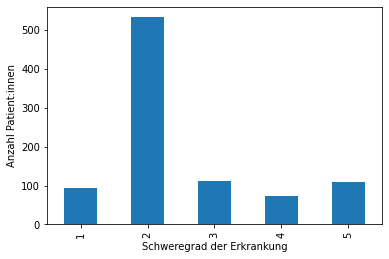

In [ ]:
# Abfrage der Daten und Erzeugung eines Pandas Dataframes
distinct_patients_and_course_of_desease = sqldf("""
    SELECT patients_id, MAX(COV_GRADING) AS course
    FROM df_faktentabelle
    GROUP BY patients_id
""")

# Herausfiltern der Patient:innen ohne Schweregrad: 
distinct_patients_and_course_of_desease = distinct_patients_and_course_of_desease[
    distinct_patients_and_course_of_desease['course'] != 0
]

# Plotten der Daten als Bar Chart
ax = distinct_patients_and_course_of_desease['course'].value_counts().sort_index().plot(kind='bar')

# Benennung der Achsen
ax.set_xlabel('Schweregrad der Erkrankung')
ax.set_ylabel('Anzahl Patient:innen')

# Plotten der Darstellung
plt.show()

Erstellung eines Data Frames von Patient:innen und deren Medikationsstatus:


In [ ]:
distinct_patients_and_medications_grading = sqldf("""SELECT patients_id, max(MED_CLASSIFICATION)as anticoagulation FROM df_faktentabelle
GROUP BY patients_id""")
distinct_patients_and_medications_grading

,patients_ID,anticoagulation
0,aaayeuzhnd,0
1,aaynxjnnby,0
2,abhdsbgojr,0
3,acdopjhgry,0
4,acmbhirfyz,0
...,...,...
1045,zxdsbpwsvx,0
1046,zxpzgesozn,0
1047,zxtzotgbuy,0
1048,zzbqpspwkp,0


Hinzufügung eines Covid Status, basierend darauf, ob die Patient:innen mit Covid diagnostiziert wurden (1) oder nicht (0):

In [ ]:
df_faktentabelle['covid'] = 0 

for i, row in df_faktentabelle.iterrows(): 
    if row.conditions_code == 840539006: 
        df_faktentabelle.at[i, 'covid'] = 1 

df_faktentabelle

,patients_ID,conditions_code,procedures_code,devices_code,MED_CLASSIFICATION,COV_GRADING,covid
0,kzjknynjzx,36955009.0,261352009.0,0.0,0,1,0
1,kzjknynjzx,386661006.0,261352009.0,0.0,0,1,0
2,kzjknynjzx,840539006.0,261352009.0,0.0,0,1,1
3,kzjknynjzx,840544004.0,261352009.0,0.0,0,1,0
4,upbzmcdmys,36955009.0,180325003.0,0.0,0,5,0
...,...,...,...,...,...,...,...
608786,nvgnnhwxes,230690007.0,180325003.0,0.0,3,5,0
608787,nvgnnhwxes,230690007.0,180325003.0,0.0,0,5,0
608788,nvgnnhwxes,230690007.0,180325003.0,0.0,0,5,0
608789,nvgnnhwxes,230690007.0,180325003.0,0.0,3,5,0


Patient:innnen und deren Covid Status:

In [ ]:
distinct_patients_and_covid_status = sqldf("""SELECT patients_id, max(covid) AS covid FROM df_faktentabelle
 GROUP BY patients_id""")
distinct_patients_and_covid_status

,patients_ID,covid
0,aaayeuzhnd,1
1,aaynxjnnby,1
2,abhdsbgojr,1
3,acdopjhgry,1
4,acmbhirfyz,1
...,...,...
1045,zxdsbpwsvx,1
1046,zxpzgesozn,1
1047,zxtzotgbuy,1
1048,zzbqpspwkp,1


Zusammenfassung der Daten von Patient:innen, Medication Grading, Schweregrad der Erkrankung und Covid Status in ein gemeinschaftliches DataFrame "PMG":  

In [ ]:
PMG = pd.merge(distinct_patients_and_course_of_desease,distinct_patients_and_medications_grading, on = "patients_ID" )
PMG["patients"]=PMG.index
PMG = pd.merge (PMG, distinct_patients_and_covid_status, on = 'patients_ID')
PMG

,patients_ID,course,anticoagulation,patients,covid
0,aaayeuzhnd,2,0,0,1
1,aaynxjnnby,2,0,1,1
2,abhdsbgojr,2,0,2,1
3,acdopjhgry,2,0,3,1
4,acmbhirfyz,2,0,4,1
...,...,...,...,...,...
914,zxdsbpwsvx,1,0,914,1
915,zxpzgesozn,3,0,915,1
916,zxtzotgbuy,2,0,916,1
917,zzbqpspwkp,2,0,917,1


# 6) Datenanalyse

## 6.1: Schweregrade des Krankheitsverlaufs

Darstellung der Verteilung der Schweregrade des Krankheitsverlaufs von Patient:innen, aufgetrennt in "behandelt" und "unbehandelt":

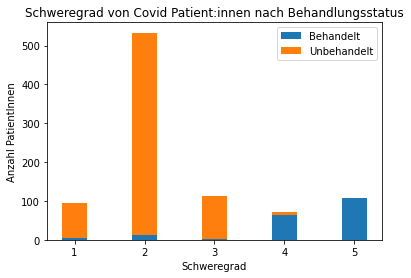

In [ ]:
PMG['anticoagulation'] = PMG['anticoagulation'].astype(int)

# Subset Daten nach Behandlungsstatus
PMG_treated = PMG[PMG['anticoagulation'] > 0]
PMG_untreated = PMG[PMG['anticoagulation'] == 0]

# Gruppierung und Auszählung Anzahl Patient:innen
PMG_treated_counts = PMG_treated.groupby('course').size().reindex(range(1, 6), fill_value=0)
PMG_untreated_counts = PMG_untreated.groupby('course').size().reindex(range(1, 6), fill_value=0)

# Barplot
fig, ax = plt.subplots()
width = 0.35
ax.bar(range(1, 6), PMG_treated_counts, width, label='Behandelt')
ax.bar(range(1, 6), PMG_untreated_counts, width, bottom=PMG_treated_counts, label='Unbehandelt')

# Beschriftung der Achsen
ax.set_xlabel('Schweregrad')
ax.set_ylabel('Anzahl PatientInnen')
ax.set_title('Schweregrad von Covid Patient:innen nach Behandlungsstatus')
ax.set_xticks(range(1, 6))
ax.legend()
plt.show()

Erzeugung eines DataFrames behandelter Covid Patient:innen: 




In [ ]:
covid_treated = sqldf("""SELECT * FROM PMG where covid = 1 and anticoagulation > 0 """)
covid_treated

,patients_ID,course,anticoagulation,patients,covid
0,aeqsigeryh,5,3,5,1
1,afolyayjzc,4,1,6,1
2,aonaydsedd,5,1,14,1
3,asxeyiwsjo,5,2,22,1
4,aucvfhbimc,2,2,24,1
...,...,...,...,...,...
171,yvrdadacyz,5,1,885,1
172,zbwfbzswno,4,1,893,1
173,zgskdmhinm,5,1,896,1
174,ztnywcsdjd,4,1,910,1


Erzeugung eines DataFrames unbehandelter Covid Patient:innen: 


In [ ]:
covid_untreated = sqldf("""SELECT * FROM PMG where covid = 1 and anticoagulation = 0 """)
covid_untreated

,patients_ID,course,anticoagulation,patients,covid
0,aaayeuzhnd,2,0,0,1
1,aaynxjnnby,2,0,1,1
2,abhdsbgojr,2,0,2,1
3,acdopjhgry,2,0,3,1
4,acmbhirfyz,2,0,4,1
...,...,...,...,...,...
684,zxdsbpwsvx,1,0,914,1
685,zxpzgesozn,3,0,915,1
686,zxtzotgbuy,2,0,916,1
687,zzbqpspwkp,2,0,917,1


## 6.2 Demographie Analyse

### 6.2.1 Geschlechter: 

Für die Analyse der Demographie, muss zusätzlich die Dimensionstabelle df_patients mit einbezogen werden, welche Informationen zum Geschlecht und Alter der Patient:innen enthält. Zu Analysenzwecken, wird das DataFrame "demographie" erstellt. 

In [ ]:
df_patients = pd.read_sql_query("SELECT * FROM d_patients", dwh_conn)

In [ ]:
demographie = pd.merge(PMG, df_patients[['PATIENTS_ID', 'PATIENTS_GENDER', 'PATIENTS_DEATHDATE', 'PATIENTS_BIRTHDATE']], left_on='patients_ID', right_on='PATIENTS_ID')

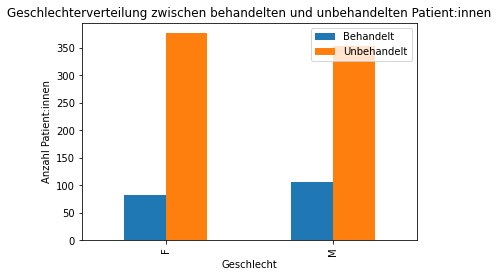

In [ ]:
import matplotlib.pyplot as plt
demographie['anticoagulation'] = demographie['anticoagulation'].astype(int)

# Gruppierung nach Geschlecht und Anzahl behandelter Covid Patient:innen 
treated_counts = demographie[demographie['anticoagulation'] > 0].groupby('PATIENTS_GENDER')['PATIENTS_GENDER'].count()

# Gruppierung nach Geschlecht und Anzahl unbehandelter Covid Patient:innen 
untreated_counts = demographie[demographie['anticoagulation'] == 0].groupby('PATIENTS_GENDER')['PATIENTS_GENDER'].count()

# Kombinierung in ein Dataframe
gender_counts = pd.concat([treated_counts, untreated_counts], axis=1, keys=['Behandelt', 'Unbehandelt'])

# Erstellung des Barplots
gender_counts.plot(kind='bar')

# Titel und Labels für Achsen
plt.title('Geschlechterverteilung zwischen behandelten und unbehandelten Patient:innen')
plt.xlabel('Geschlecht')
plt.ylabel('Anzahl Patient:innen')

# Anzeigen des Plots
plt.show()

Berechnung der Verteilung zwischen weiblichen und männlichen Patient:innen: 

In [ ]:
# Gruppieren des Demographie DataFrames nach Geschlecht und Berechnung der Anzahl Patient:innen in jeder Gruppe. 
covid_counts_by_gender = demographie[demographie['covid'] == 1].groupby('PATIENTS_GENDER')['covid'].count()

# Resultate
print("Number of men and women with COVID:")
print(covid_counts_by_gender)

Number of men and women with COVID:
PATIENTS_GENDER
F    435
M    430
Name: covid, dtype: int64


Untersuchung der Abhängigkeit zwischen den Variablen: 

In [ ]:

# Konvertierung der Antikoagulation Spalte in einen int Datentypen. 
demographie['anticoagulation'] = demographie['anticoagulation'].astype(int)

# Filtern der Patient:innen nach Covid (covid == 1)
demographie_covid = demographie[demographie['covid'] == 1]

# Geschlecht und Behandlungsstatus
contingency_table = pd.crosstab(demographie_covid['PATIENTS_GENDER'], demographie_covid['anticoagulation'])

# chi2-Test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results
print("Chi-squared Testresultate")
print("chi2 =", chi2)
print("p =", p)

Chi-squared Testresultate
chi2 = 5.486315006409468
p = 0.13945942656187224


Die Geschlechterverteilung zwischen behandelten und unbehandelten Patient:innen ist ähnlich. Es lässt sich nicht mit Gewissheit sagen, ob sie signifikant ist. 

### 6.2.2 Alter: 





In [ ]:
# Heutiges Jahr
current_year = datetime.datetime.now().year

# Berechnung des Alters vom Geburtsjahr ausgehend
demographie['age'] = current_year - pd.to_datetime(demographie['PATIENTS_BIRTHDATE']).dt.year

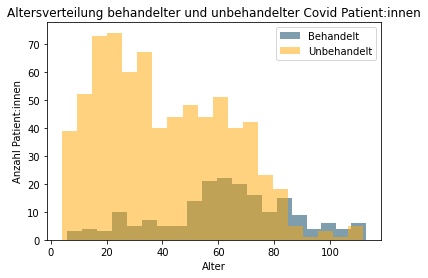

In [ ]:
# Histogramm Alter behandelter Covid Patient:innen
plt.hist(demographie[demographie['anticoagulation'] > 0]['age'], bins=20, alpha=0.5, color='#003f5c', label='Behandelt')

# Histogramm Alter unbehandelter Covid Patient:innen
plt.hist(demographie[demographie['anticoagulation'] == 0]['age'], bins=20, alpha=0.5, color='#ffa600', label='Unbehandelt')

# Titel und Labels für Achsen
plt.xlabel('Alter')
plt.ylabel('Anzahl Patient:innen')
plt.title('Altersverteilung behandelter und unbehandelter Covid Patient:innen')

# Legende
plt.legend()

# Anzeigen des Plotst
plt.show()

Untersuchung der Signifikanz der Altersverteilung: 

In [ ]:
# Extrahieren des Alters der Patient:innen
age_treated = demographie[demographie['anticoagulation'] > 0]['age']
age_untreated = demographie[demographie['anticoagulation'] == 0]['age']

# T-Test
t_stat, p_val = ttest_ind(age_treated, age_untreated, equal_var=False)

print('T-test Resultate:')
print(f't-Statistik: {t_stat:.2f}')
print(f'p-Wert: {p_val:.3f}')

T-test Resultate:
t-Statistik: 11.69
p-Wert: 0.000


Die Altersverteilung zwischen behandelten und unbehandelten Patient:innen ist unterschiedlich und die Varianz ist signifikant. Da jedoch die Anzahl der behandelten Patient:innen deutlich geringer als die der unbehandelten Patient:innen ist, wird dies in der Analyse vernachlässigt. 

## 6.3 Überprüfung Forschungsfrage 1

### Patient:innen mit Antikoagulation weisen im Vergleich zu nicht-antikoagulierten Patient:innen einen leichteren klinischen Covid 19-Erkrankungsverlauf auf.


Im Nachfolgenden wird der Unterschied der Schweregrade zwischen behandelten und unbehandelten Patient:innen untersucht. 
Die Hypothese lautet: Patient:innen mit Antikoagulation weisen im Vergleich zu nicht-antikoagulierten Patient:innen einen leichteren klinischen Covid 19-Erkrankungsverlauf auf.

In [ ]:
# Durschnittlicher Schweregrade behandelter Patient:innen
avg_severity_in_patients_with_anticoagulation = covid_treated ['course'].mean()

## Durschnittlicher Schweregrade unbehandelter Patient:innen
avg_severity_in_patients_without_anticoagulation = covid_untreated ['course'].mean()

##Vergleich Schweregrad behandelter und unbehandelter Patient:innen
if avg_severity_in_patients_with_anticoagulation < avg_severity_in_patients_without_anticoagulation:
    print("The average severity of disease is lower in treated patients compared to untreated patients.")
elif avg_severity_in_patients_with_anticoagulation > avg_severity_in_patients_without_anticoagulation:
    print("The average severity of disease is higher in treated patients compared to untreated patients.")
else:
    print("The average severity of disease is the same in treated and untreated patients.")

The average severity of disease is higher in treated patients compared to untreated patients.


In [ ]:
# Kalkulation Statistik & p-Value
t_statistic, p_value = stats.ttest_ind(covid_treated ['course'], covid_untreated ['course'], equal_var=False)

# Berechnung, ob p-value <0.05
if p_value < 0.05:
    print("The difference in average severity between treated and untreated patients is statistically significant, the p-value is", p_value)
else:
    print("The difference in average severity between treated and untreated patients is not statistically significant, the p-value is", p_value)

The difference in average severity between treated and untreated patients is statistically significant, the p-value is 5.626641550264907e-78


Daraus ergibt sich, dass der Schweregrad der Erkrankung bei Patient:innen signifikant höher ist, welche mit Antikoagulantien behandelt worden sind. Hypothese 1 kann somit widerlegt werden. 

Der nachfolgende Graph stellt eine Heatmap dar, welche die Patient:innen und den Schweregrad der Erkrankung abhängig von der gewählten Behandlungsmethode anzeigt. 

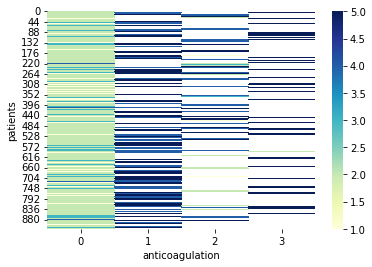

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Laden der Daten
df_data = sqldf("""SELECT patients, anticoagulation, course FROM PMG """)

# Pivot Table
df_pivot = df_data.pivot('patients','anticoagulation','course',)

# Heatmap
sns.heatmap(df_pivot, cmap='YlGnBu')

# Anzeigen des Plots
plt.show()

In diesem Abschnitt wird Hypothese 2 untersucht: Heparinderivate sind mit einem besseren klinischen Covid-19-Verlauf als andere Antikoagulantien assoziiert.

## 6.4 Überprüfung Forschungsfrage 2

### Heparinderivate sind mit einem besseren klinischen Covid-19-Verlauf als andere Antikoagulantien assoziiert.

In [ ]:
covid_treated_heparin = sqldf("""SELECT * FROM PMG where covid = 1 and anticoagulation = 1 """)
covid_treated_heparin

,patients_ID,course,anticoagulation,patients,covid
0,afolyayjzc,4,1,6,1
1,aonaydsedd,5,1,14,1
2,bfxgqvdogd,5,1,41,1
3,bprsoatxga,4,1,48,1
4,bqvxuedsfz,4,1,49,1
...,...,...,...,...,...
102,yvrdadacyz,5,1,885,1
103,zbwfbzswno,4,1,893,1
104,zgskdmhinm,5,1,896,1
105,ztnywcsdjd,4,1,910,1


In [ ]:
covid_treated_nonheparin = sqldf("""SELECT * FROM PMG where covid = 1 and anticoagulation > 1 """)
covid_treated_nonheparin 

,patients_ID,course,anticoagulation,patients,covid
0,aeqsigeryh,5,3,5,1
1,asxeyiwsjo,5,2,22,1
2,aucvfhbimc,2,2,24,1
3,aydnhihvzp,5,3,31,1
4,btyjioeamc,5,3,52,1
...,...,...,...,...,...
64,xfpqktikoo,5,3,823,1
65,xhjcjwnxqm,5,2,827,1
66,xmxqvyazab,2,2,837,1
67,ycvqgzetdq,5,3,854,1


In [ ]:
## Durschnittlicher Schweregrade Heparin behandelter Patient:innen
avg_severity_in_patients_with_heparin = covid_treated_heparin['course'].mean()

## Durschnittlicher Schweregrade Heparin unbehandelter Patient:innen
avg_severity_in_patients_without_heparin = covid_treated_nonheparin ['course'].mean()

## Vergleich Schweregrad Heparin behandelter und unbehandelter Patient:innen
if avg_severity_in_patients_with_heparin < avg_severity_in_patients_without_heparin:
    print("The average severity of disease is lower in patients with heparin treatment compared to patients without heparin treatment.")
elif avg_severity_in_patients_with_heparin > avg_severity_in_patients_without_heparin:
    print("The average severity of disease is higher in patients with heparin treatment compared to patients without heparin treatment.")
else:
    print("The average severity of disease is the same in patients with heparin treatment and patients without heparin treatment.")


The average severity of disease is higher in patients with heparin treatment compared to patients without heparin treatment.


In [ ]:
# Kalkulation Statistik & p-Value
t_statistic, p_value = stats.ttest_ind(covid_treated_heparin ['course'], covid_treated_nonheparin ['course'], equal_var=False)

# Berechnung, ob p-value <0.05
if p_value < 0.05:
    print("The difference in average severity between heparin treated and non-heparin treated patients is statistically significant, the p-value is", p_value)
else:
    print("The difference in average severity between heparin treated and non-heparin treated patients is not statistically significant, the p-value is", p_value)

The difference in average severity between heparin treated and non-heparin treated patients is statistically significant, the p-value is 0.0018293471787816972


Daraus ergibt sich, dass der Schweregrad der Erkrankung bei Patient:innen, welche mit Heparinderivaten behandelt worden sind, signifikant höher ist, als der Patient:innen, welche mit anderen Antikoagulantien behandelt worden sind. Hypothese 2 kann somit widerlegt werden. 